In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.train import run_model_new
from src.utils_plot import plot_loss_and_all_solution, plot_head_loss
from src.load_save import save_model

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [2]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Thu Jan 11 18:40:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              N/A /   5W |   1942MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
num_heads = 12
equation_name = "nonlinear_easy"

np.random.seed(42)
# generate the training stiffness parameter alpha
alpha_bounds = (1, 100)
def generate_alpha(k, alpha_bounds = alpha_bounds):
  alpha_list = np.zeros(k)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list
alpha_list = generate_alpha(num_heads)

# create the A matrix associated with the ODE
def get_A(alpha):
    return torch.tensor([[alpha, 0.], [-1., 0.]], device=dev).double() 
A_list = [get_A(i)for i in alpha_list]

# training IC (random or not)
def random_IC(x_bound=[1, 3], y_bound=[0, 2]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev)
IC_list = [random_IC() for i in range(num_heads)]
#IC_list = [torch.tensor([[2.], [0.]], device=dev).double() for _ in range(num_heads)]

# training force (random or not)
def random_force(force1_bound=[0, 2], force2_bound=[0, 2]):
    force1 = np.random.uniform(force1_bound[0], force1_bound[1], 1)
    force2 = -np.random.uniform(force2_bound[0], force2_bound[1], 1)
    return torch.tensor([force1, force2], device=dev)
force_list = [random_force() for i in range(num_heads)]
#force_list = [torch.tensor([[0.], [1.]], device=dev).double() for _ in range(num_heads)]

C:\Users\Emilien\AppData\Local\Temp\ipykernel_4112\1281810448.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor([ICx, ICy], device=dev)


In [4]:
x_range = [0, 5]
activation = "tanh"
hid_lay = list(np.array([124, 124, 132]) * 1)
num_equations = 2
iterations = 10000

In [5]:
sample_size = 200
lr = 0.00005
decay = True
verbose = True

# run model which has two non-coupled equations
loss_hist, trained_model, model_time = run_model_new(iterations=iterations, x_range=x_range, lr=lr,
                                                           A_list=A_list, v_list=IC_list, force=force_list,
                                                           hid_lay=hid_lay, activation=activation,
                                                           num_equations=num_equations, num_heads=num_heads,
                                                           sample_size = sample_size, decay=decay, dev=dev, verbose=verbose)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 0/10000 [00:00<?, ?it/s]

Iterations 0: loss = 70.43803694485314


  5%|▌         | 501/10000 [01:15<14:15, 11.11it/s] 

Iterations 500: loss = 2.6707456256850555


 10%|█         | 1003/10000 [17:19<12:47, 11.72it/s]    

Iterations 1000: loss = 2.360905431172515


 15%|█▌        | 1501/10000 [18:01<11:52, 11.93it/s]

Iterations 1500: loss = 2.248504564650501


 20%|██        | 2003/10000 [18:46<11:17, 11.80it/s]

Iterations 2000: loss = 2.1201771516987034


 25%|██▌       | 2501/10000 [19:29<19:23,  6.44it/s]

Iterations 2500: loss = 2.0969320993707816


 30%|███       | 3003/10000 [20:14<09:53, 11.78it/s]

Iterations 3000: loss = 2.0113528870504442


 35%|███▌      | 3501/10000 [20:56<09:15, 11.70it/s]

Iterations 3500: loss = 1.972980461485777


 40%|████      | 4003/10000 [21:39<08:27, 11.82it/s]

Iterations 4000: loss = 1.8621077044327796


 45%|████▌     | 4503/10000 [22:21<07:44, 11.84it/s]

Iterations 4500: loss = 1.8407767329259643


 50%|█████     | 5003/10000 [23:04<07:07, 11.70it/s]

Iterations 5000: loss = 1.8027522171925425


 55%|█████▌    | 5501/10000 [23:46<06:16, 11.94it/s]

Iterations 5500: loss = 1.7419791789691828


 60%|██████    | 6003/10000 [24:28<05:58, 11.14it/s]

Iterations 6000: loss = 1.6993121461812268


 65%|██████▌   | 6501/10000 [25:10<05:12, 11.19it/s]

Iterations 6500: loss = 1.67660308364419


 70%|███████   | 7001/10000 [25:52<04:12, 11.90it/s]

Iterations 7000: loss = 1.6256351614288176


 75%|███████▌  | 7503/10000 [26:34<03:32, 11.74it/s]

Iterations 7500: loss = 1.6475259621720475


 80%|████████  | 8002/10000 [27:16<02:46, 12.01it/s]

Iterations 8000: loss = 1.5495702290735063


 85%|████████▌ | 8502/10000 [27:58<02:04, 12.02it/s]

Iterations 8500: loss = 1.518940458490338


 90%|█████████ | 9002/10000 [28:40<01:21, 12.19it/s]

Iterations 9000: loss = 1.457656186724576


 95%|█████████▌| 9502/10000 [29:21<00:41, 11.99it/s]

Iterations 9500: loss = 1.4802465697272802


100%|██████████| 10000/10000 [30:03<00:00,  5.54it/s]


Model Training Complete in 1803.688 seconds


In [6]:
# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][1] * y[1] - A[0][0] * y[0],
                     force[1].detach().item() - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

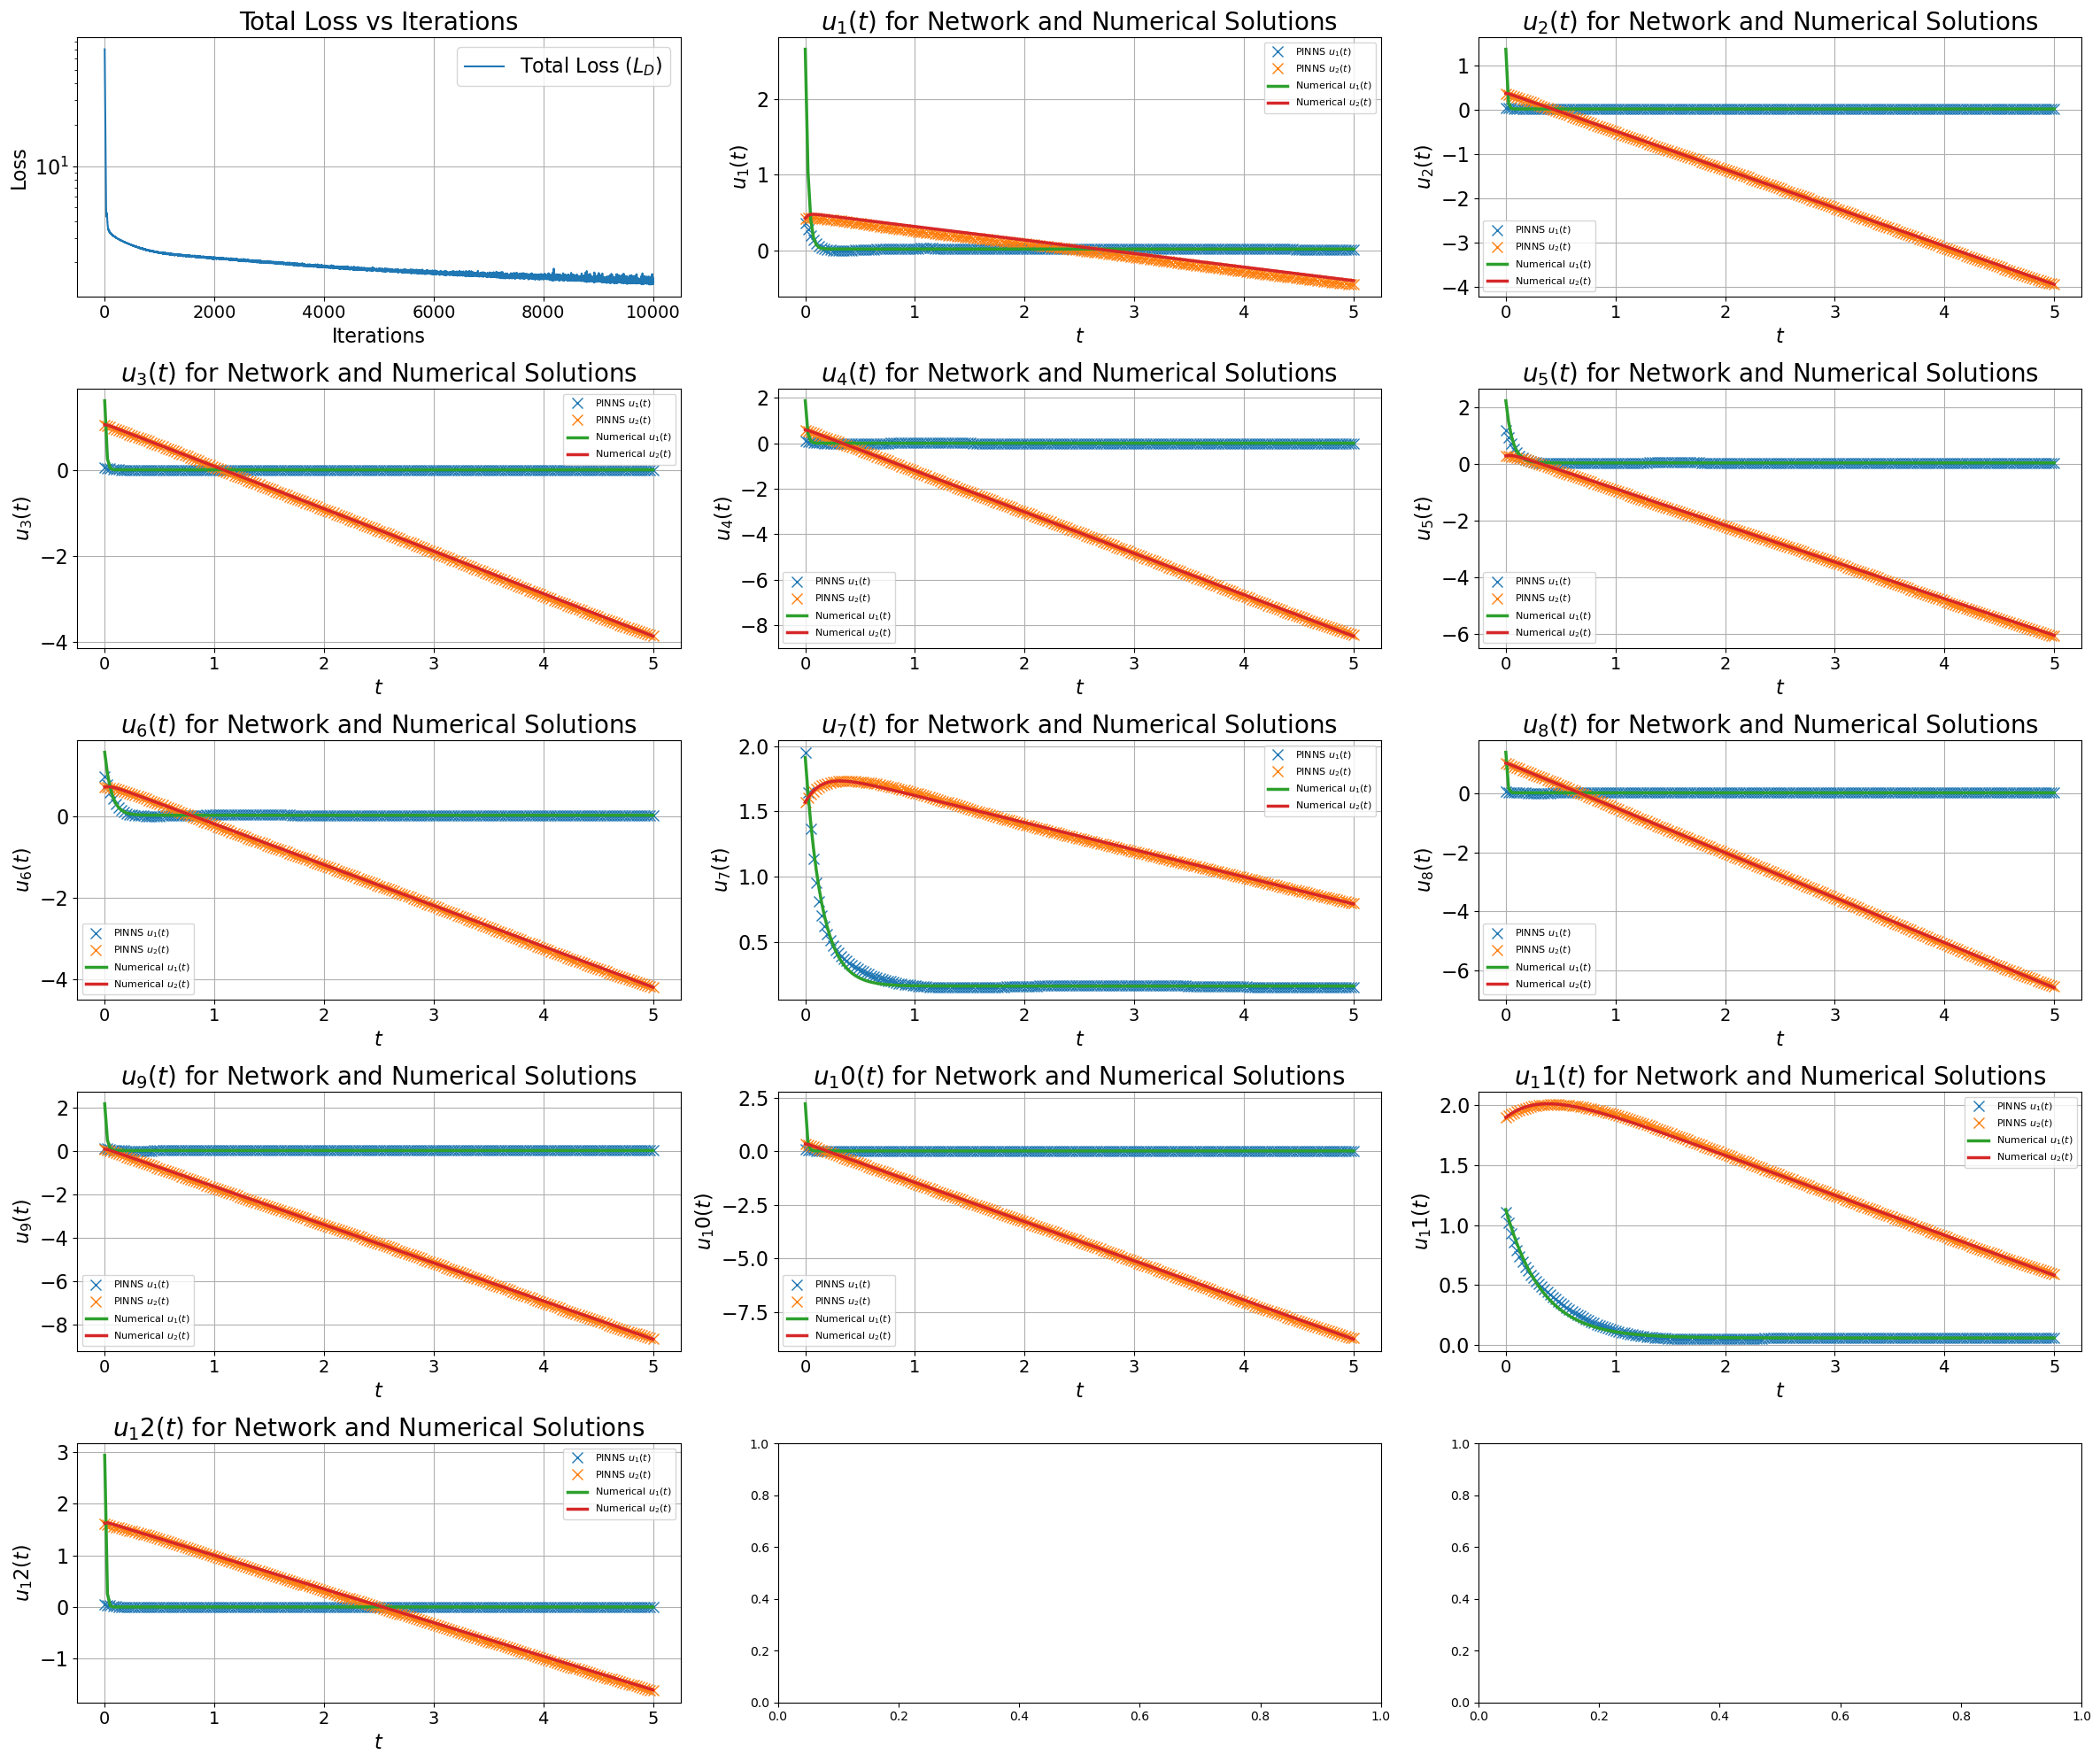

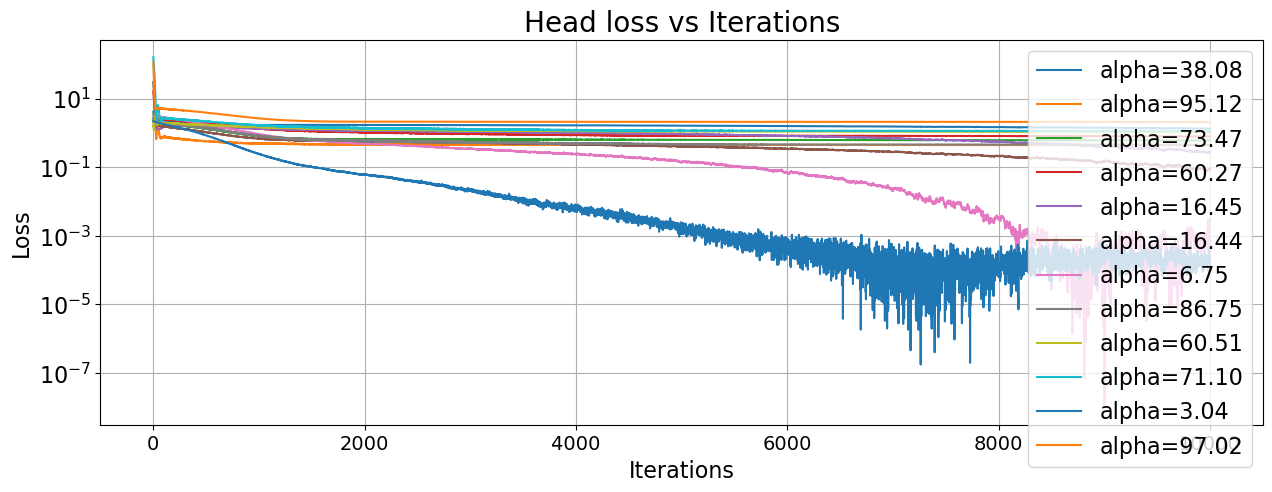

In [7]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,
                           trained_model=trained_model, v_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist['L_total'],
                           loss_label='Total Loss ($L_D$)', device=dev)
plot_head_loss(loss_hist["head"], alpha_list)

In [18]:
model_name = "inference"
save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, alpha_list, loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/nonlinear_easy/history_inference_1111630.json
